In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison
from matplotlib.colors import LinearSegmentedColormap
from random import randint, seed
from utils import stack4plot, similarity_multi, similarity_multiplication
from utils_vis import overlapMasks

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


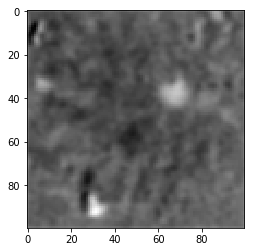

In [2]:
dataset = np.load('/home/kevinteng/Desktop//jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')

#hyperparameter 
NEW_SIZE = 100
ver = '08' #version no.
BATCH_SIZE = 8
lr=0.00001
n_neurons = 200
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


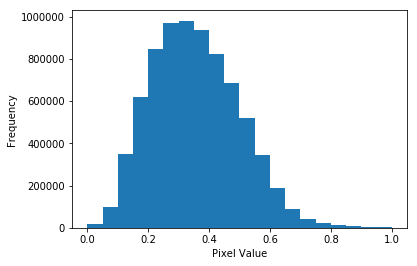

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Validation

In [5]:
coords,_, ori_one_hot_imgs = utils_model.create_dat_samples(n_neurons, IMG_SIZE)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[200 1 1 2]


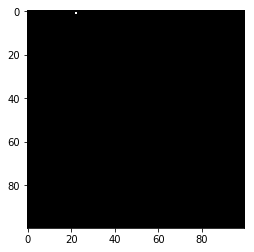

In [6]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [7]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same')(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same')(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same')(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same')(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same')(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size, img_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def decoder(latent_dim):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_coord_block(dense_01, up_size = 2, x_dim = 50, y_dim = 50, filters = 64, 
                           kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = Conv2D(filters = 1, kernel_size = 3, strides = 1,
                    padding = 'same', activation = None)(up_02)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y

In [8]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [9]:
#build encoder 
inps = Input(shape=(IMG_SIZE, IMG_SIZE, 1))
encoder_model = Model(inps, encoder(inps, IMG_SIZE))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim))

#learnable coords
l_coords = learnable_coords(coords)

## Train Model

--------------------------------------

In [10]:
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #output from encoder 
        encoder_output = encoder_model(inp_imgs)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size, IMG_SIZE)#(batch_size, n_neurons, 3, 1)
        #reconstruction 
        reconstruction = decoder_model(latent)
        loss = loss_fn(inp_imgs, reconstruction)
        
    varis = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(loss, varis)
#     grad_coords = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(grad_model, varis))
#     opt.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model 

In [11]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

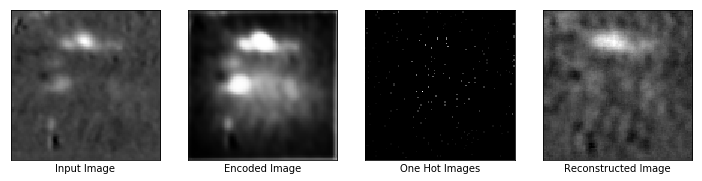

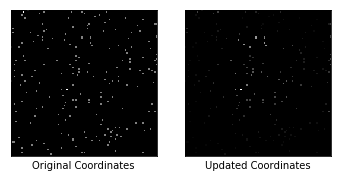

Epochs: 100, Loss: 0.002230212790891528
Max Similarity scores: 0.999680757522583
Updated Coordinates: [[[0.2222434  0.01011624]]]
Gradient min:-0.002507824217900634, max:0.0018173734424635768



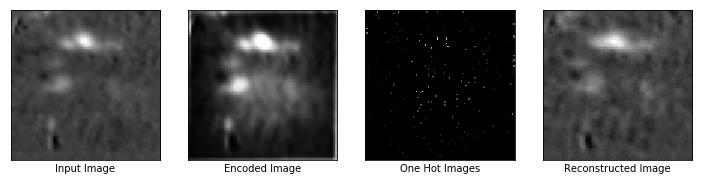

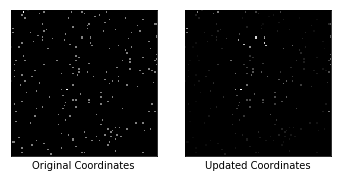

Epochs: 200, Loss: 0.001301680225878954
Max Similarity scores: 0.9981072545051575
Updated Coordinates: [[[0.22223882 0.0101285 ]]]
Gradient min:-0.0022209868766367435, max:0.001487051835283637



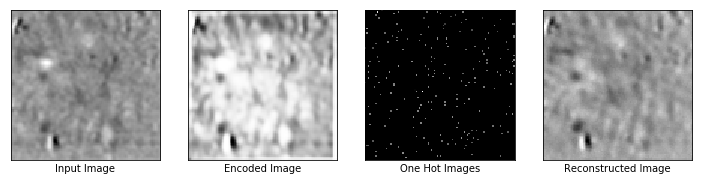

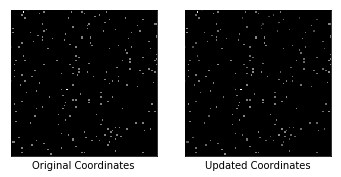

Epochs: 300, Loss: 0.0010867668315768242
Max Similarity scores: 0.9999464154243469
Updated Coordinates: [[[0.22223228 0.01013737]]]
Gradient min:-0.0004531033046077937, max:0.002356321085244417



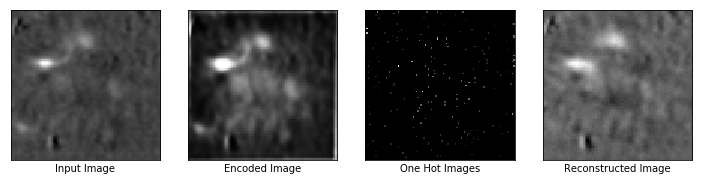

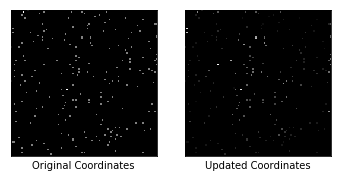

Epochs: 400, Loss: 0.0008850235026329756
Max Similarity scores: 0.9992271661758423
Updated Coordinates: [[[0.22222896 0.01013965]]]
Gradient min:-0.0012725993292406201, max:-0.0012725993292406201



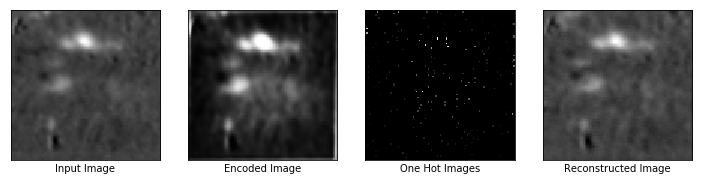

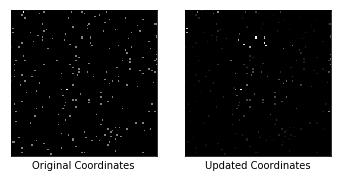

Epochs: 500, Loss: 0.0007471207645721734
Max Similarity scores: 0.9980565905570984
Updated Coordinates: [[[0.22223584 0.01013771]]]
Gradient min:-0.0015925276093184948, max:0.0015681151999160647



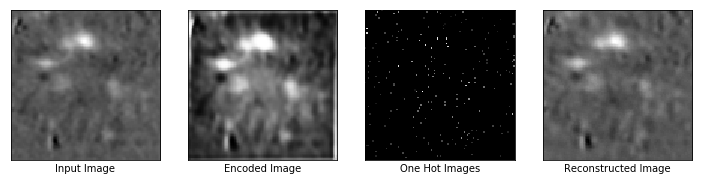

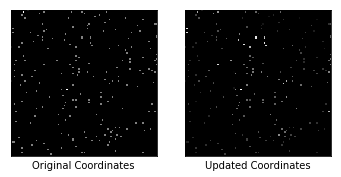

Epochs: 600, Loss: 0.0006582796340808272
Max Similarity scores: 0.9979351758956909
Updated Coordinates: [[[0.22224136 0.01014015]]]
Gradient min:-0.002798218745738268, max:0.0011218024883419275



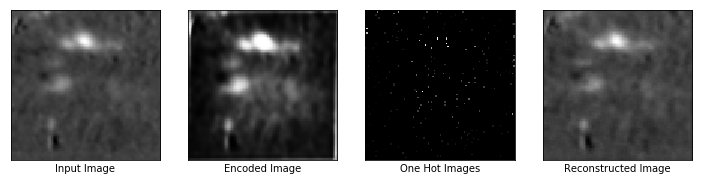

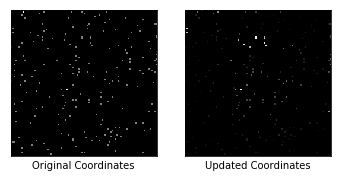

Epochs: 700, Loss: 0.0006505542551167309
Max Similarity scores: 0.9985964298248291
Updated Coordinates: [[[0.22224556 0.01014297]]]
Gradient min:-0.004436956252902746, max:0.003075558692216873



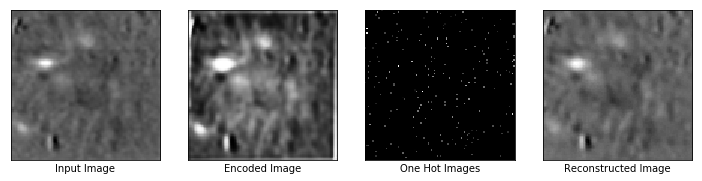

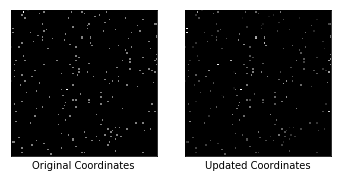

Epochs: 800, Loss: 0.0006722785183228552
Max Similarity scores: 0.9997124671936035
Updated Coordinates: [[[0.2222271  0.01015645]]]
Gradient min:-0.0005192704265937209, max:0.0005800409126095474



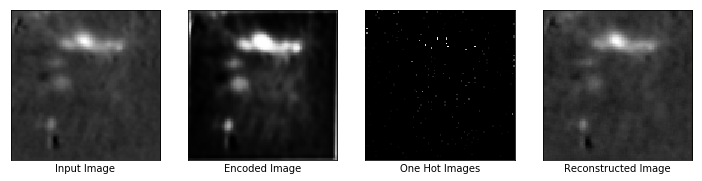

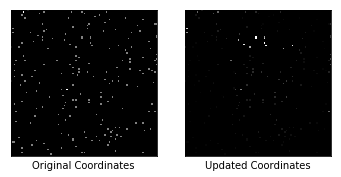

Epochs: 900, Loss: 0.0006080978782847524
Max Similarity scores: 0.9976374506950378
Updated Coordinates: [[[0.22223793 0.01015278]]]
Gradient min:-0.0023629460483789444, max:0.00175188179127872



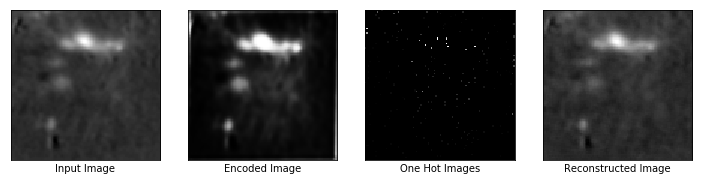

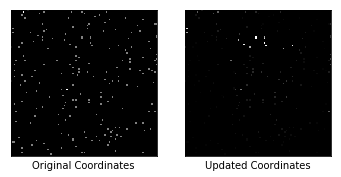

Epochs: 1000, Loss: 0.0004953253082931042
Max Similarity scores: 0.9982857704162598
Updated Coordinates: [[[0.22226794 0.01014969]]]
Gradient min:-0.0007837630691938102, max:0.001005656667985022



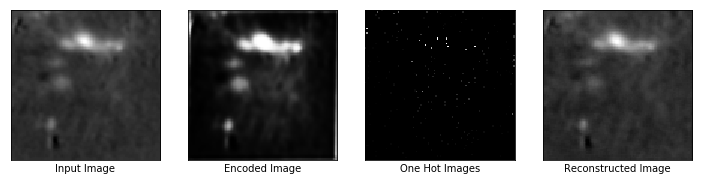

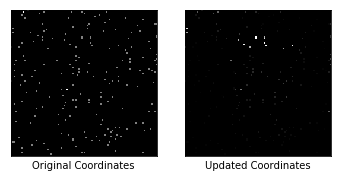

Epochs: 1100, Loss: 0.0005146217299625278
Max Similarity scores: 0.9987757802009583
Updated Coordinates: [[[0.22227746 0.01014543]]]
Gradient min:-0.000999797717668116, max:0.0016895061125978827



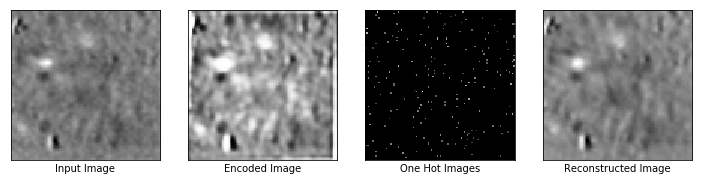

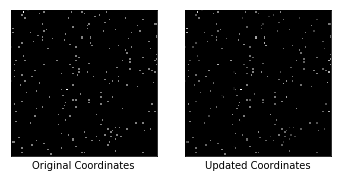

Epochs: 1200, Loss: 0.0004661149578168988
Max Similarity scores: 0.9999815821647644
Updated Coordinates: [[[0.22225505 0.01015455]]]
Gradient min:-0.0012893816456198692, max:0.0015825810842216015



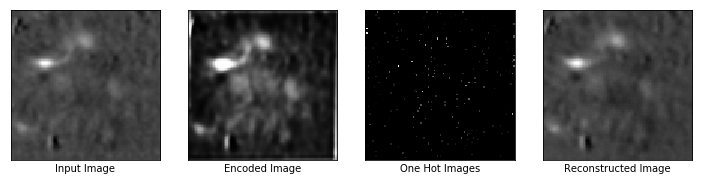

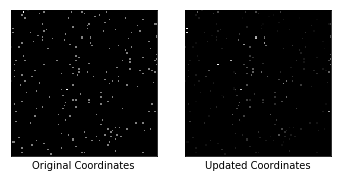

Epochs: 1300, Loss: 0.00048278135363943875
Max Similarity scores: 0.9998692870140076
Updated Coordinates: [[[0.22227485 0.01014663]]]
Gradient min:-0.004666307475417852, max:-0.004666307475417852



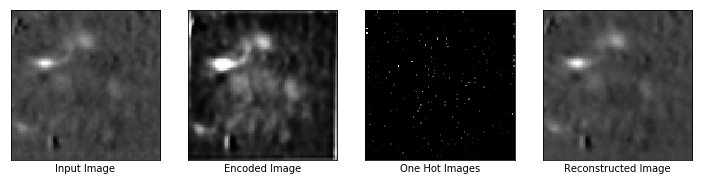

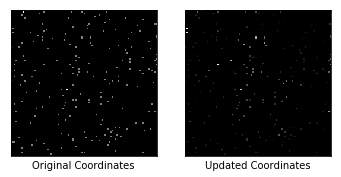

Epochs: 1400, Loss: 0.0003975640283897519
Max Similarity scores: 0.9997595548629761
Updated Coordinates: [[[0.22227675 0.01014695]]]
Gradient min:-0.0034174679312855005, max:-0.0034174679312855005



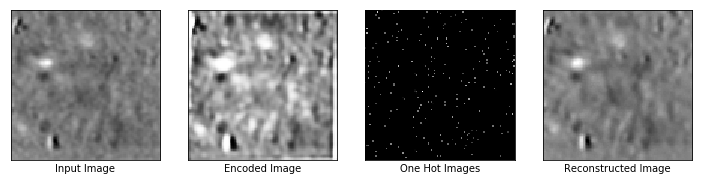

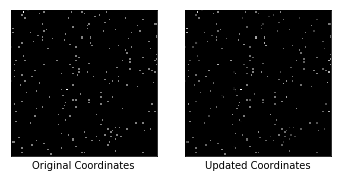

Epochs: 1500, Loss: 0.0004327084170654416
Max Similarity scores: 0.9999860525131226
Updated Coordinates: [[[0.22225375 0.01015657]]]
Gradient min:-0.001444580964744091, max:0.001346777193248272



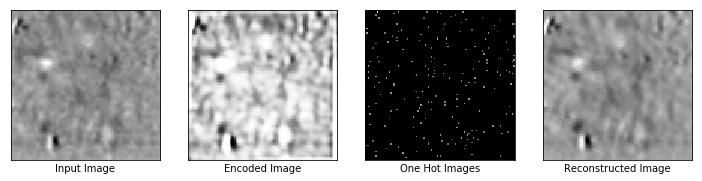

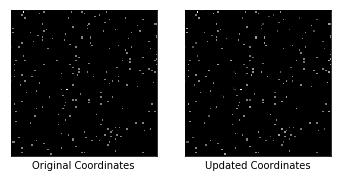

Epochs: 1600, Loss: 0.0005279724719002843
Max Similarity scores: 0.9999991059303284
Updated Coordinates: [[[0.22226632 0.01014879]]]
Gradient min:-0.0017807016847655177, max:0.0005311878630891442



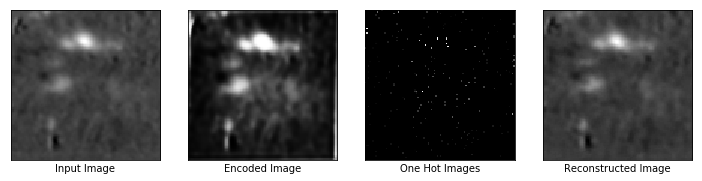

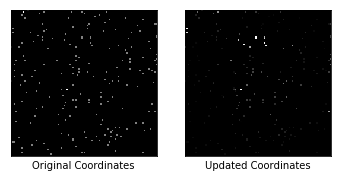

Epochs: 1700, Loss: 0.00035387687967158854
Max Similarity scores: 0.9987664222717285
Updated Coordinates: [[[0.22226875 0.01014866]]]
Gradient min:-0.0015486008487641811, max:0.0019014364806935191



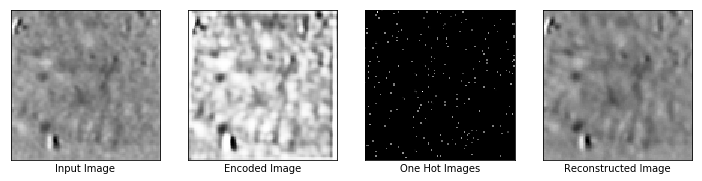

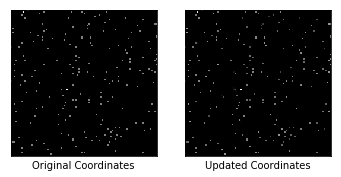

Epochs: 1800, Loss: 0.0004935319302603602
Max Similarity scores: 0.9999994039535522
Updated Coordinates: [[[0.22226313 0.01015242]]]
Gradient min:0.00614894600585103, max:0.00614894600585103



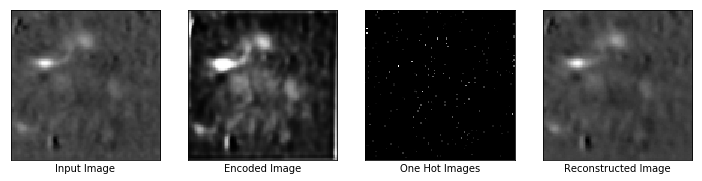

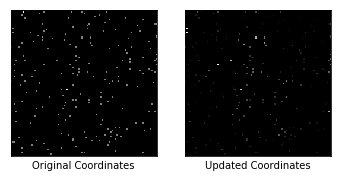

Epochs: 1900, Loss: 0.00034342490835115314
Max Similarity scores: 0.9998812675476074
Updated Coordinates: [[[0.22225747 0.01015159]]]
Gradient min:0.004689858295023441, max:0.004689858295023441



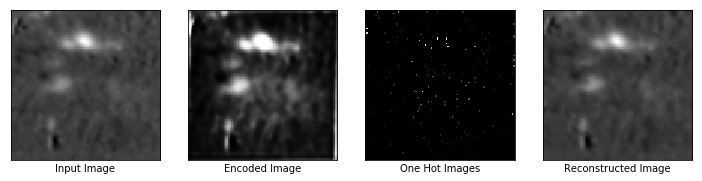

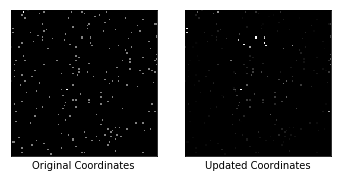

Epochs: 2000, Loss: 0.0003870592045132071
Max Similarity scores: 0.9992954134941101
Updated Coordinates: [[[0.22227025 0.01014873]]]
Gradient min:-0.0025856117717921734, max:0.003236137330532074


In [12]:
MAX_EPOCHS = 2000
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

#list to append to monitor each frames for the last epochs 
one_hot_imgs_last_list = []
encoder_output_last_list = []
similarity_score_last_list = []
reconstruction_last_list = []

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model  = train_fn(batched_imgs, coords, IMG_SIZE, BATCH_SIZE)
        #append all frames for final epochs!
        if epochs==MAX_EPOCHS:
            one_hot_imgs_last_list.append(one_hot_imgs)
            encoder_output_last_list.append(encoder_output)
            similarity_score_last_list.append(similarity_score)
            reconstruction_last_list.append(reconstruction)
    #loss is append for each epochs
    loss_list.append(loss)
    
    rand = randint(0, BATCH_SIZE-1) #random number to generate for plotting outputs 
    if epochs%100==0:
        img_row01 = [batched_imgs[rand], encoder_output[rand], similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE), reconstruction[rand]]
        img_row02 = [stack4plot(ori_one_hot_imgs), similarity_multi(n_neurons, one_hot_imgs, similarity_score[rand], IMG_SIZE)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Loss: {}".format(epochs, loss.numpy()))
        print("Max Similarity scores: {}".format(np.max(similarity_score[rand])))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient min:{}, max:{}".format(np.min(grad_model[rand]), np.max(grad_model[rand])))
    #append list for every 100 epochs 
#     if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [33]:
save_list = [loss_list, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
save_names = ['loss_list', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

directory = 'npy/{}'.format(ver)
#make directory to save
if not os.path.exists(directory):
    os.makedirs(directory)
    
for names, items in zip(save_names, save_list):
    tensor = tf.convert_to_tensor(items, tf.float32)
    np.save('npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(tensor))
    

In [34]:
#save coords and one hot images()
np.save('npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver), np.array(coords))
np.save('npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver), np.array(ori_one_hot_imgs))

In [35]:
#save info for every frames in last epochs
save_list_last = [encoder_output_last_list, similarity_score_last_list, reconstruction_last_list]
save_names_last = ['encoder_output_last_list', 'similarity_score_last_list', 'reconstruction_last_list']

for names, items in zip(save_names_last, save_list_last):
    aggregate_tensor = utils.concat_batch(items)
    np.save('npy/{}/{}_full{}.npy'.format(ver, names, ver), np.array(aggregate_tensor))

In [36]:
#save one hot imgs for last epochs 
tensor = tf.convert_to_tensor(one_hot_imgs_last_list, tf.float32) #(frames/batch, n_neurons, img_size, img_size, 1)
np.save('npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver), np.array(tensor))

In [37]:
#save weights
encoder_model.save_weights('model_weights/encoder_model_{}.h5'.format(ver))
decoder_model.save_weights('model_weights/decoder_model_{}.h5'.format(ver))

---

# Visualization

In [38]:
coords_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'coords_list', ver)) 
encoded_imgs_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'encoded_imgs', ver))
input_imgs_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'input_imgs', ver))
loss_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'loss_list', ver))
one_hot_imgs_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_list', ver))
reconstructed_imgs_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'reconstructed_imgs', ver))
similarity_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'similarity_list', ver))
ori_coords_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'ori_coords', ver))
ori_one_hot_imgs_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'ori_one_hot_imgs', ver))

In [39]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

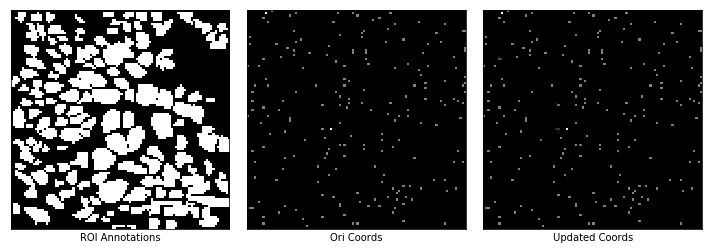

In [40]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

Mean value:  0.02
Counts:  197


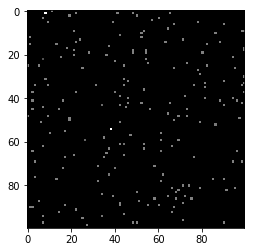

In [41]:
sum_updated_coords = stack4plot(one_hot_imgs_list_npy[-1])
print("Mean value: ", np.mean(sum_updated_coords))
updated_coords_img = np.where(sum_updated_coords<0.5, 0, sum_updated_coords) 
activations_count = np.count_nonzero(updated_coords_img!=0)
print("Counts: ", activations_count)
plt.imshow(updated_coords_img, cmap = 'gray')

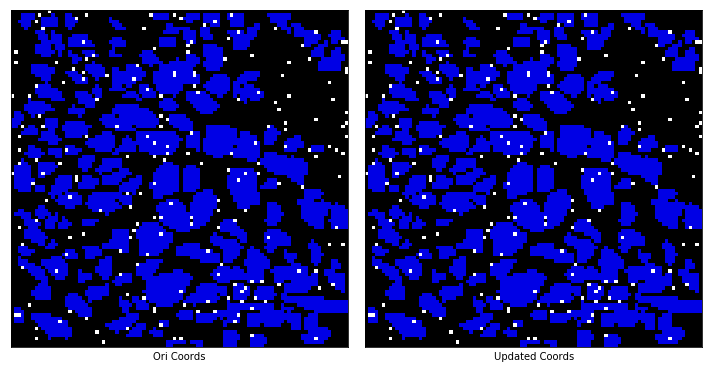

In [23]:
#define color
colors = [(0, 0, 0), (0, 1, 0), (0, 0, 0.9)] 
cm = LinearSegmentedColormap.from_list('mylist', colors, 3)  

#overlap mask with original coordinates 
roi_ori_mask = overlapMasks(roi_img, stack4plot(ori_one_hot_imgs_npy))

#overlap mask with updated coordinates 
roi_updated_mask = overlapMasks(roi_img, updated_coords_img)

captions_04 = ['Ori Coords', 'Updated Coords']
img_row04 = [roi_ori_mask, roi_updated_mask]
plot_comparison(img_row04, captions_04, n_col=len(img_row04), figsize = (10, 10), cmap = cm)

In [ ]:
#confusion matrix 
utils.getConfusionMatrix(roi_img, updated_coords_img)

---

# Similarity Scores with Threshold

In [24]:
neuron_activations, neuron_activations_thr = similarity_multiplication(similarity_list_npy, one_hot_imgs_list_npy, 
                                                                       n_neurons, epoch_pos=-1, 
                                                                       img_size = IMG_SIZE, threshold = 0.8)

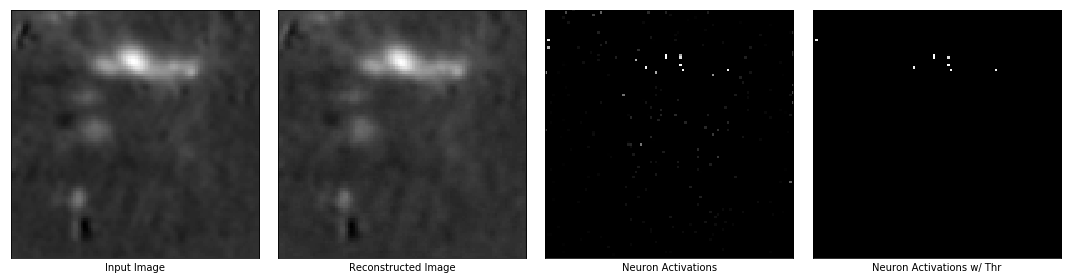

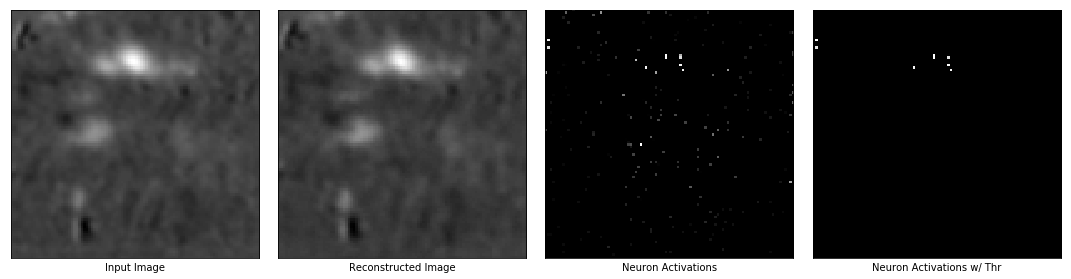

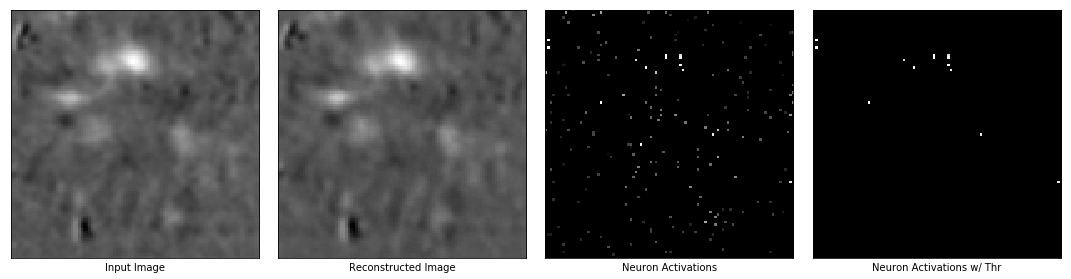

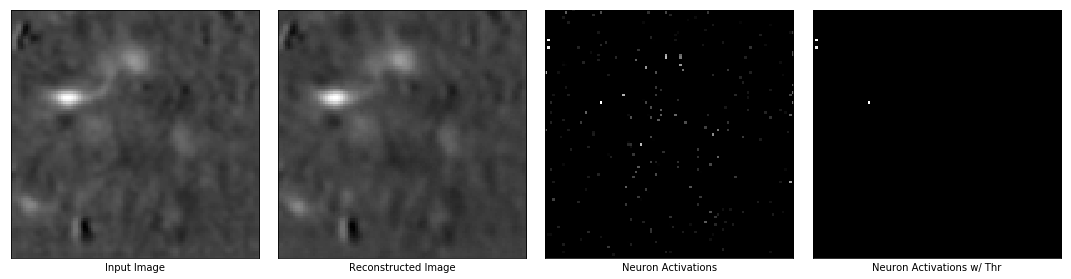

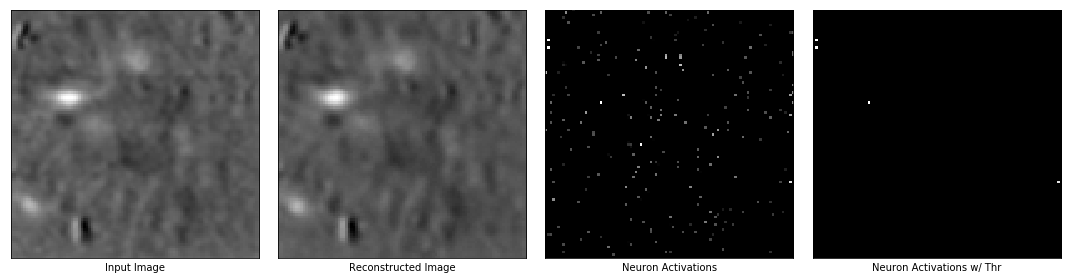

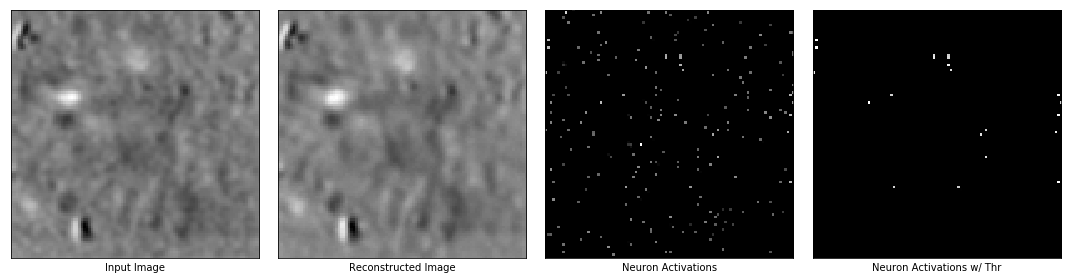

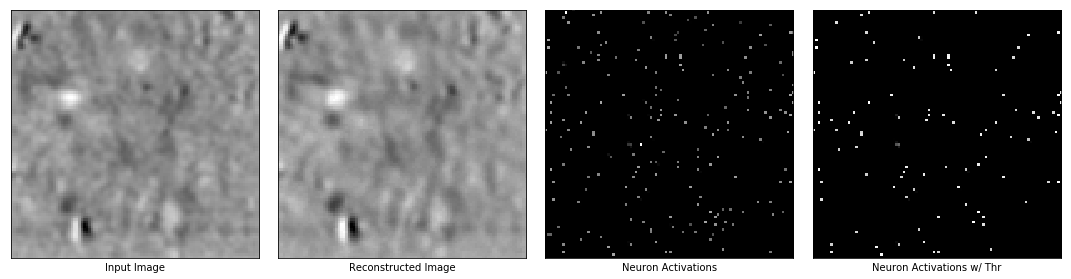

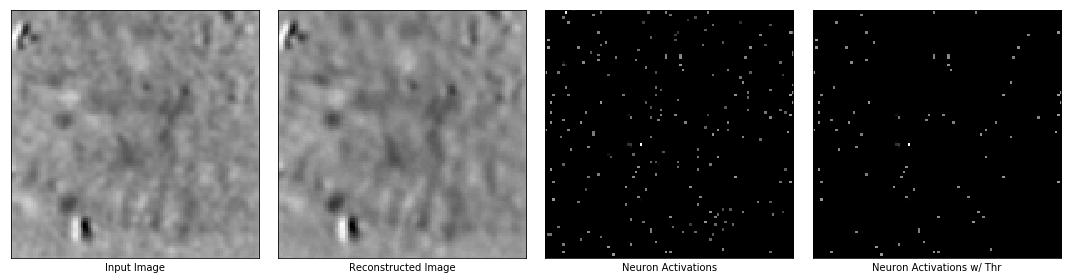

In [25]:
batch_size = BATCH_SIZE
captions_03 = ['Input Image', 'Reconstructed Image','Neuron Activations', 'Neuron Activations w/ Thr']
for i in range(batch_size):
    img_row03 = [np.squeeze(input_imgs_npy[-1,i]), np.squeeze(reconstructed_imgs_npy[-1,i]), neuron_activations[i], neuron_activations_thr[i]]
    plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (15, 15))

## Loss Plot

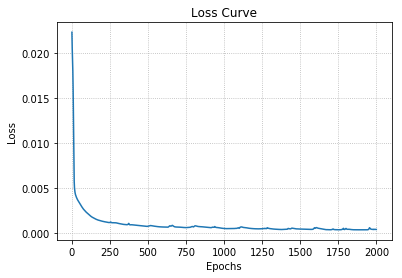

In [26]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_npy, xlabel, ylabel, title)

## Feature Maps

In [27]:
decoder_layers_name = utils_vis.layers_name(decoder_model) 

input_3
flatten_1
dense
reshape
up_sampling2d
coord_conv_14
activation
up_sampling2d_1
conv2d_22
activation_1
conv2d_23


In [28]:
#concat latent space as input
squeeze_coords = np.squeeze(coords_list_npy[-1]) #use the last pos
similarity_score = similarity_list_npy[-1]


concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[0]), axis=-1)
concat_ex = concat[np.newaxis,:,:,np.newaxis] #extand axis=0 and axis=-1 for input into model
print(concat_ex.shape)

(1, 200, 3, 1)


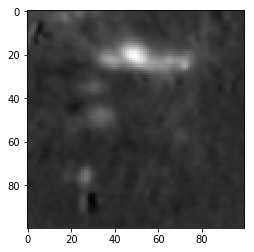

In [29]:
plt.imshow(np.squeeze(input_imgs_npy[-1,0]), cmap = 'gray')

Shape of feature maps: (1, 50, 50, 64)
Number of feature maps in layer:  64


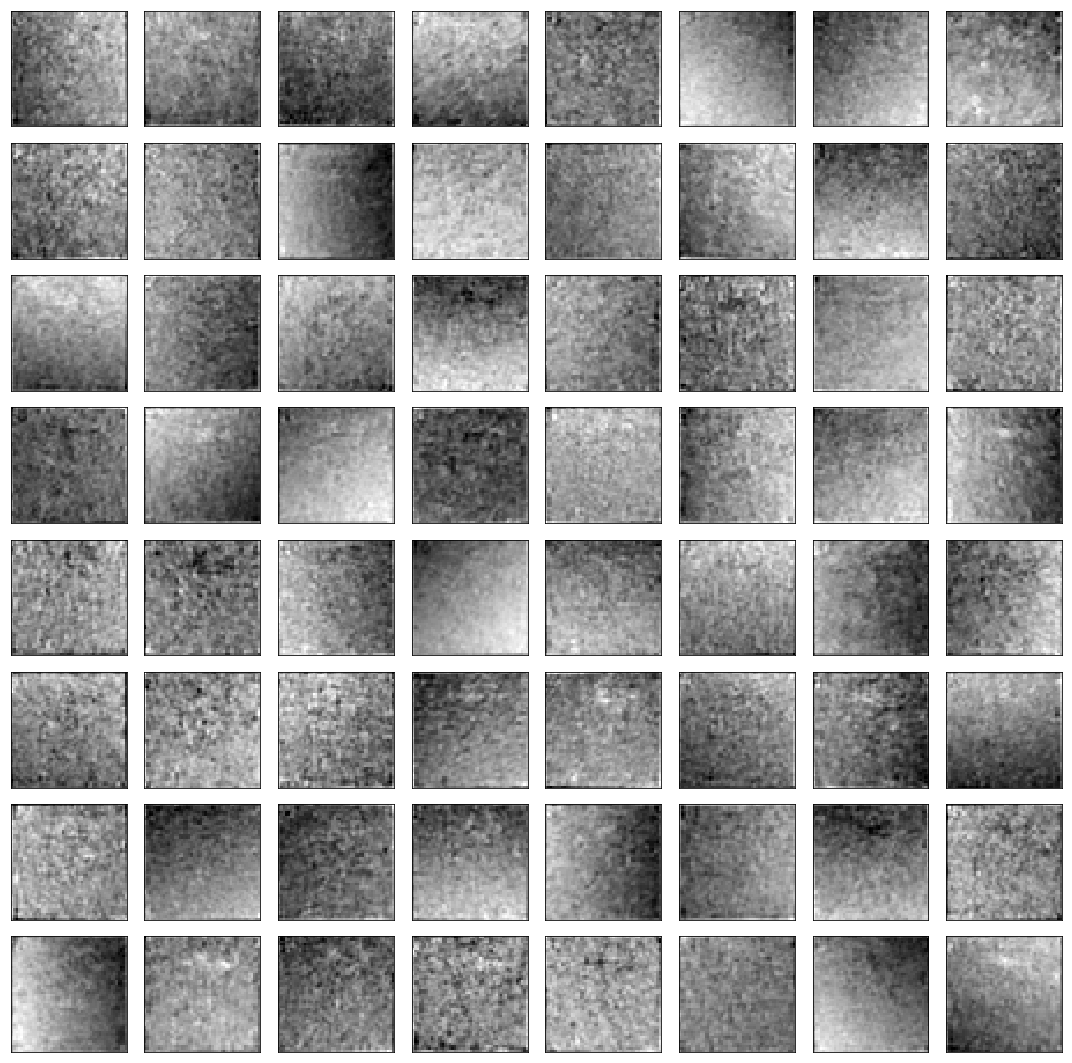

In [30]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'coord_conv_14', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 8, 8, figsize=(15,15))

Shape of feature maps: (1, 100, 100, 32)
Number of feature maps in layer:  32


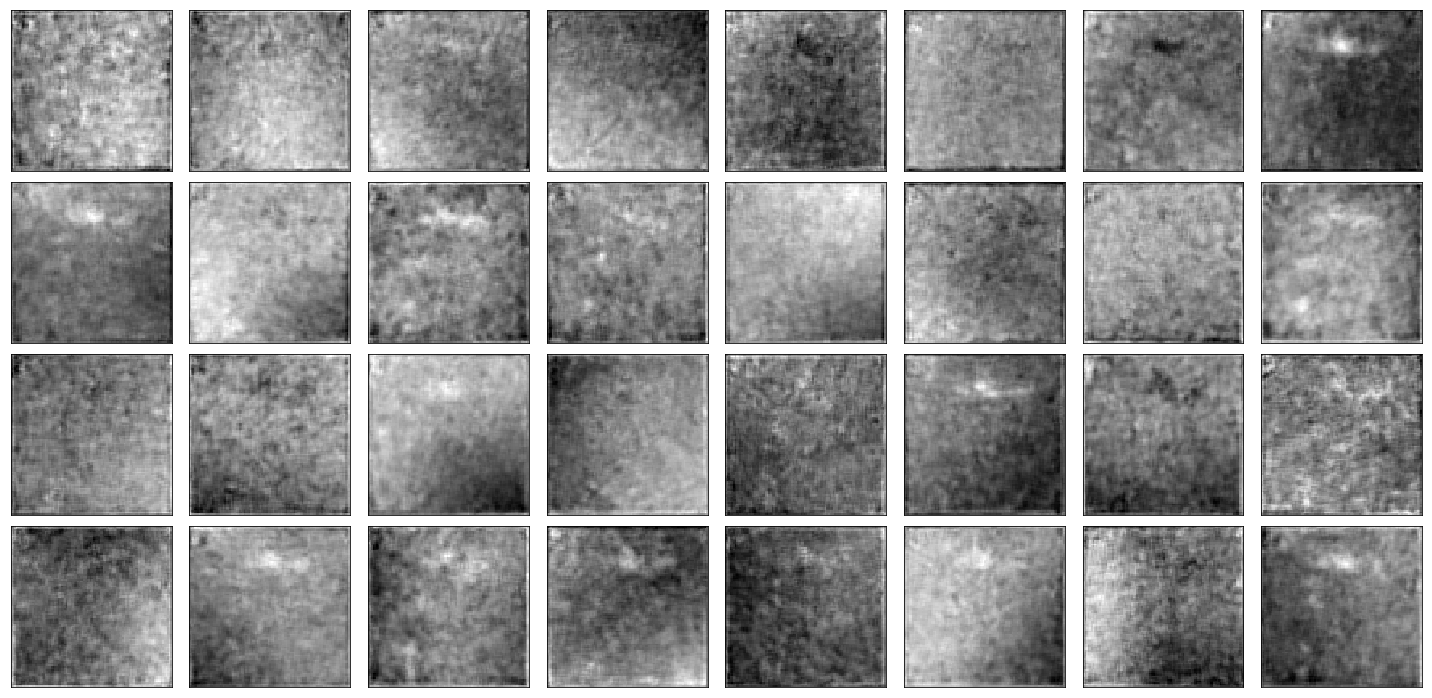

In [31]:
coord_conv_feature_maps = utils_vis.feature_maps(decoder_model, 'conv2d_22', concat_ex)
utils_vis.plot_feature_maps(coord_conv_feature_maps, 4, 8, figsize=(20,10))

---

# Visualization Per-frame

In [32]:
one_hot_imgs_last_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'one_hot_imgs_last_list', ver))
encoder_output_last_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'encoder_output_last_list', ver))
similarity_score_last_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'similarity_score_last_list', ver))
reconstruction_last_list_npy = np.load('npy/{}/{}_full{}.npy'.format(ver, 'reconstruction_last_list', ver))

In [ ]:

def multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, img_size, batch_size):
    '''
    Multiply similarity scores for every one hot pixel images and aggregate the one hot images into
    single frames
    
    @param one_hot_imgs_last_list_npy: .npy array of one hot images for the last epochs 
    @param similarity_score_last_list_npy: .npy array of similarity score for the last epochs
    @param img_size: image size
    @param batch_size: batch size
    
    return 
    tensor of one hot images multiplied with similarity scores for each images 
    '''
    count = 0
    onehot_list = []
    for one_hot in np.squeeze(one_hot_imgs_last_list_npy):
        if count!=len(similarity_score_last_list_npy): 
            for idx in range(count,count+batch_size): #loop through the similarity score for every batch_size increment
                sum_multi = np.zeros((img_size, img_size))
                for n in range(len(one_hot)): #n_neurons
                    multi = similarity_score_last_list_npy[idx, n]*one_hot[n]
                    sum_multi+=multi #sum all the one hot images
                onehot_list.append(sum_multi)
        count+=batch_size
        tensor = tf.convert_to_tensor(onehot_list, tf.float32)
    
    return tensor

In [ ]:
tensor = multi_similarity_frame(one_hot_imgs_last_list_npy, similarity_score_last_list_npy, IMG_SIZE, BATCH_SIZE)

## Maximum Intensity Projection

In [ ]:
tensor_sum = np.max(tensor, axis = 0)

In [ ]:
# roi_ori_mask = overlapMasks(roi_img, tensor_sum)
plt.imshow(tensor_sum, cmap = 'gray')